<img src='imgs/google_scholar_elastic.png' width='850' />

# Indexing research papers from <u>Google Scholar</u> with <u>Elastic + Kibana</u> using <u>Docker</u> containers
# <u><i>demo</i></u>

### 1. Scrape Google Scholar
### 2. AI-NLP
#####    * Named Entity
#####    * Topic Modeling
### 3. ElasticSearch Docker Container
### 4. Index Results
### 5. Dashboard - Kibana Docker Container

#  


<img src='imgs/google_scholar.png' width='250' />

# 1. Scrape Google Scholar -- Python API

https://pypi.org/project/scholarly/

### scrape Google Scholar

In [195]:
import scholarly
result = next(scholarly.search_pubs_query('china virus')).bib

StopIteration: 

### sample results

In [ ]:
import json
print(json.dumps(result, indent=4))

### paper title

In [33]:
print(result['title'].replace('\u03b2','-B'))

A DNA-B associated with Tomato yellow leaf curl China virus is required for symptom induction


### authors

In [34]:
print(result['author'])

X Cui and X Tao and Y Xie and CM Fauquet and X Zhou


### abstract

In [35]:
print(result['abstract'])

We report here that all 25 isolates of Tomato yellow leaf curl China virus (TYLCCNV) collected from tobacco, tomato, or Siegesbeckia orientalis plants in different regions of Yunnan Province, China, were associated with DNAβ molecules. To investigate the …


# 2. AI-NLP
###  NER + Topic Modeling

<img src='imgs/ai_logo.svg' width='950' />

https://towardsdatascience.com/named-entity-recognition-with-nltk-and-spacy-8c4a7d88e7da  
https://github.com/explosion/spaCy/issues/4577#issuecomment-552320320  

### spaCy

In [106]:
!python -m spacy download en_core_web_sm -q
import spacy
from spacy import displacy
import en_core_web_sm
nlp = en_core_web_sm.load()
from wordcloud import WordCloud

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


### scrape a few Google Scholar papers

In [101]:
results = []
for index, result in enumerate(scholarly.search_pubs_query('china virus')):
    results.append(result.bib)
    if index > 3: break
clob = '. '.join(['.  '.join(r.values()) for r in results])        

In [102]:
results[1]['abstract'].split('.')[1].strip() + '.'

'Here, we have investigated variations accumulating in Tomato yellow leaf curl ….'

### Parts of Speech _POS_

In [103]:
displacy.render(sp(str(results[1]['abstract'].split('.')[1].strip() + '.')), style='dep', jupyter=True)

# Named Entity Recognition _NER_

In [189]:
displacy.render(sp(clob), style='ent', jupyter=True)

### Ye Olde 
# Word Cloud

In [150]:
remove = ['https','org','pdf','content','curl']

In [151]:
%%time
results = []
for index, result in enumerate(scholarly.search_pubs_query('china virus')):
    results.append(result.bib)
    if index > 10: break
clob = '. '.join(['.  '.join(r.values()) for r in results])

CPU times: user 195 ms, sys: 4.21 ms, total: 199 ms
Wall time: 13.3 s


In [152]:
for r in remove:
    clob = clob.replace(r,'')

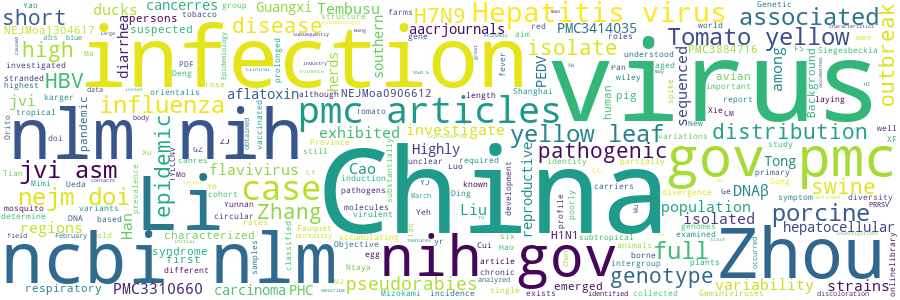

In [168]:
wordcloud = WordCloud(background_color="white", 
                      max_words=4000, 
                      contour_width=50, 
                      contour_color='red',
                      width=900, height=300, margin=2,)
wordcloud.generate(clob)
wordcloud.to_image()

# Topic Modeling

https://github.com/kapadias/mediumposts/blob/master/nlp/published_notebooks/Introduction%20to%20Topic%20Modeling.ipynb

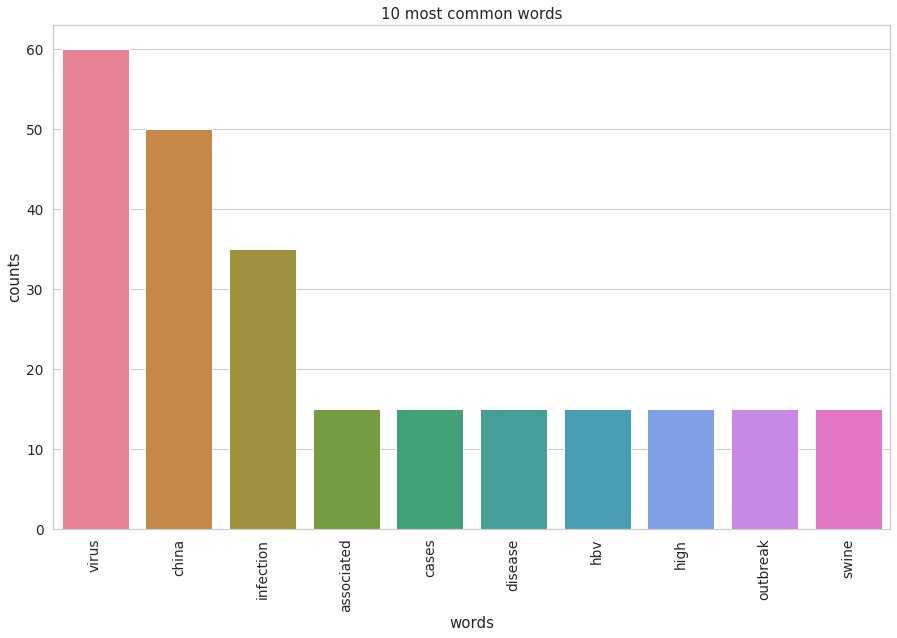

In [154]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

# Helper function
def plot_10_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()

# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english')

# Fit and transform the processed titles
abstracts = [a.replace(r,'') for r in remove for a in [r['abstract'] for r in results]]
count_data = count_vectorizer.fit_transform(abstracts)

# Visualise the 10 most common words
plot_10_most_common_words(count_data, count_vectorizer)

# Topics

In [155]:
# Load the LDA model from sk-learn
from sklearn.decomposition import LatentDirichletAllocation as LDA
 
# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
# Tweak the two parameters below (use int values below 15)
number_topics = 5
number_words = 10

# Create and fit the LDA model
lda = LDA(n_components=number_topics)
lda.fit(count_data)

# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, count_vectorizer, number_words)

Topics found via LDA:

Topic #0:
infection china virus tomato phc 25 suspected persons isolates southern

Topic #1:
infection virus china isolates associated influenza background cases curl regions

Topic #2:
hbv infection china virus distribution high investigate hepatitis exists classified

Topic #3:
cases china h7n9 background influenza regions yellow leaf characteristics analyzed

Topic #4:
virus outbreak disease swine china associated flavivirus exhibited sequenced strains


# Latent Dirichlet Allocation -- _visualized

In [187]:
%%time
from pyLDAvis import sklearn as sklearn_lda
import pickle 
import pyLDAvis
import os
LDAvis_data_filepath = os.path.join('./ldavis_prepared_'+str(number_topics))
LDAvis_prepared = sklearn_lda.prepare(lda, count_data, count_vectorizer)
pyLDAvis.save_html(LDAvis_prepared, './ldavis_prepared_'+ str(number_topics) +'.html')

CPU times: user 187 ms, sys: 85.8 ms, total: 273 ms
Wall time: 1.17 s


In [188]:
from IPython.display import HTML
HTML(filename='./ldavis_prepared_'+ str(number_topics) +'.html')

http://localhost:8888/view/ldavis_prepared_5.html

<img src='imgs/elastic.png' width='850'/>

# 3. ElasticSearch Docker Container

In [190]:
elastic_version    = '7.6.1'

h_elastic_rest_port  = '9200'
c_elastic_rest_port  = '9200'
h_elastic_node_comms = '9300'
c_elastic_node_comms = '9300'

!docker run -d                                                \
            -p {h_elastic_rest_port}:{c_elastic_rest_port}    \
            -p {h_elastic_node_comms}:{c_elastic_node_comms}  \
            -e "discovery.type=single-node"                   \
            -it                                               \
            -h elasticsearch                                  \
            --name elasticsearch                              \
            elasticsearch:{elastic_version}

docker: Error response from daemon: Conflict. The container name "/elasticsearch" is already in use by container "052c9f13944c7ed6ee414cb40aeadb75c97723a090ec92fdcd5cfb723b3982d3". You have to remove (or rename) that container to be able to reuse that name.
See 'docker run --help'.


### verify 

In [191]:
!docker ps | grep elasticsearch

052c9f13944c        elasticsearch:7.6.1    "/usr/local/bin/dock…"   9 hours ago         Up 9 hours          0.0.0.0:9200->9200/tcp, 0.0.0.0:9300->9300/tcp   elasticsearch


In [192]:
!wget http://localhost:9200/ -q -O -

{
  "name" : "elasticsearch",
  "cluster_name" : "docker-cluster",
  "cluster_uuid" : "-VnhfK4FRF-Qo1UM57OHbQ",
  "version" : {
    "number" : "7.6.1",
    "build_flavor" : "default",
    "build_type" : "docker",
    "build_hash" : "aa751e09be0a5072e8570670309b1f12348f023b",
    "build_date" : "2020-02-29T00:15:25.529771Z",
    "build_snapshot" : false,
    "lucene_version" : "8.4.0",
    "minimum_wire_compatibility_version" : "6.8.0",
    "minimum_index_compatibility_version" : "6.0.0-beta1"
  },
  "tagline" : "You Know, for Search"
}


# 4. Index Research Papers
# Indexing Corona Research Papers

https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge#metadata.csv

https://medium.com/naukri-engineering/elasticsearch-tutorial-for-beginners-using-python-b9cb48edcedc  

In [3]:
import pandas as pd

In [4]:
df = pd.read_csv('corona.csv.zip')

In [14]:
df.head(2)

,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,Microsoft Academic Paper ID,WHO #Covidence,has_full_text,full_text_file
0,NaN,Elsevier,Intrauterine virus infections and congenital h...,10.1016/0002-8703(72)90077-4,NaN,4361535.0,els-covid,Abstract The etiologic basis for the vast majo...,1972-12-31,"Overall, James C.",American Heart Journal,NaN,NaN,False,custom_license
1,NaN,Elsevier,Coronaviruses in Balkan nephritis,10.1016/0002-8703(80)90355-5,NaN,6243850.0,els-covid,NaN,1980-03-31,"Georgescu, Leonida; Diosi, Peter; Buţiu, Ioan;...",American Heart Journal,NaN,NaN,False,custom_license


In [15]:
df.head(2).to_json()

'{"sha":{"0":null,"1":null},"source_x":{"0":"Elsevier","1":"Elsevier"},"title":{"0":"Intrauterine virus infections and congenital heart disease","1":"Coronaviruses in Balkan nephritis"},"doi":{"0":"10.1016\\/0002-8703(72)90077-4","1":"10.1016\\/0002-8703(80)90355-5"},"pmcid":{"0":null,"1":null},"pubmed_id":{"0":4361535.0,"1":6243850.0},"license":{"0":"els-covid","1":"els-covid"},"abstract":{"0":"Abstract The etiologic basis for the vast majority of cases of congenital heart disease remains largely undefined. Viruses have been considered to be likely candidates since the recognition of the association between intrauterine rubella and congenital heart disease. Although the pathogenesis of cardiovascular defects is poorly understood, information gained from the study of congenital rubella syndrome suggests that mechanisms such as focal endothelial cell damage, resulting in obliteration of vascular supply, decreased growth rate, and shortened survival time of certain cells, and disturbed D

In [17]:
df.head(2).to_dict('records')[1]

{'sha': nan,
 'source_x': 'Elsevier',
 'title': 'Coronaviruses in Balkan nephritis',
 'doi': '10.1016/0002-8703(80)90355-5',
 'pmcid': nan,
 'pubmed_id': 6243850.0,
 'license': 'els-covid',
 'abstract': nan,
 'publish_time': '1980-03-31',
 'authors': 'Georgescu, Leonida; Diosi, Peter; Buţiu, Ioan; Plavoşin, Livia; Herzog, Georgeta',
 'journal': 'American Heart Journal',
 'Microsoft Academic Paper ID': nan,
 'WHO #Covidence': nan,
 'has_full_text': False,
 'full_text_file': 'custom_license'}

In [ ]:
res = es.index(index='scholar_scrape', doc_type='scholar_search', id=result['url'], body=result)


In [2]:
# Import Elasticsearch package 
from elasticsearch import Elasticsearch 
# Connect to the elastic cluster
es=Elasticsearch([{'host':'localhost','port':9200}])
es

<Elasticsearch([{'host': 'localhost', 'port': 9200}])>

### connect to Google Scholar

In [ ]:
search_query = scholarly.search_keyword('Virology')

In [ ]:
e1={
    "first_name":"nitin",
    "last_name":"panwar",
    "age": 27,
    "about": "Love to play cricket",
    "interests": ['sports','music'],
}
print e1
{'interests': ['sports', 'music'], 'about': 'Love to play cricket', 'first_name': 'nitin', 'last_name': 'panwar', 'age': 27}

In [ ]:
#Now let's store this document in Elasticsearch 
res = es.index(index='megacorp',doc_type='employee',id=1,body=e1)

<img src='imgs/kibana.png' width='450' />

# 5. Dashboard -- Kibana Docker Container

### NOTE: Kibana takes a couple minutes to start

In [193]:
h_kibana_port        = '5601'
c_kibana_port        = '5601'
!docker run -d                                  \
            -p {h_kibana_port}:{c_kibana_port}  \
            -h kibana                           \
            --name kibana                       \
            --link elasticsearch:elasticsearch  \
            kibana:{elastic_version}

docker: Error response from daemon: Conflict. The container name "/kibana" is already in use by container "bfde7510bd11e51e68c67ef07d4129ef44f8a359959469a297c26fb398466bb6". You have to remove (or rename) that container to be able to reuse that name.
See 'docker run --help'.


### verify

In [194]:
!docker ps | grep kibana

bfde7510bd11        kibana:7.6.1           "/usr/local/bin/dumb…"   9 hours ago         Up 9 hours          0.0.0.0:5601->5601/tcp                           kibana


### Wait a few minutes, click the link below, then refresh page until Kibana loads

http://localhost:5601

<img src='imgs/kibana_screen_761.png' width='550' />

### I click <i><u>Explore on my own</u></i> for this demonstration

# stop & kill

In [4]:
!docker stop kibana        && docker rm kibana
!docker stop elasticsearch && docker rm elasticsearch

kibana
kibana
elasticsearch
elasticsearch
